In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import glob
sys.path.append('../')

from collections import OrderedDict

import numpy as np

from rankutils.stat_mr import StatMR
from rankutils.rIO import read_rank
from rankutils.mappings import exp_aliases
from rankutils.cfgloader import cfgloader
from rankutils.clustering import clustering_1d
from rankutils.features import *
from rankutils.extraction import get_name_in_coll

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

from time import time

In [3]:
fwr = StatMR(dist_name='WBL', k=10, method='fixed', opt_metric='MCC', verbose=False)
fwr = StatMR(dist_name='WBL', k=10, method='mixt', opt_metric='MCC', verbose=False)
k = 10

np.set_printoptions(precision=15, suppress=True)

In [4]:
def load_namelist(fpath):

    dt = dict(names=('name', 'numfeat', 'cid'), formats=('U100', np.int32, np.int32))
    namelist = np.loadtxt(fpath, dtype=dt)

    return namelist

In [5]:
def get_idx(qname, topk, namelist):
    
    q_idx = np.argwhere(namelist == qname)[0, 0]
    
    nsort = np.argsort(namelist)
    pos = np.searchsorted(namelist[nsort], topk)
    topk_idx = nsort[pos]
    
    return q_idx, topk_idx

In [18]:
pathcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg")
key_order = ['unicamp_001', 'places365_001', 'imagenet_001', 'vggfaces_001']
            
#key_order = ['oxford_001', 'oxford_002', 'unicamp_001']

# tables = OrderedDict(delta=OrderedDict(), sdct=OrderedDict(),
#                     cld=OrderedDict(), accjacc=OrderedDict(),
#                     cidjacc=OrderedDict())

tables = OrderedDict(fscr=OrderedDict(), gl=OrderedDict(), cs=OrderedDict())

for key in tqdm(key_order, desc='Key ', total=len(key_order)):
    
    aux = glob.glob(pathcfg.get(key, "collmatches") + "*" + pathcfg.get(key, "rktpdir") + "*db_matches*")[0]
    collmatches = np.load(aux)[:, 0:100]
    
    aux = glob.glob(pathcfg.get(key, "collmatches") + "*" + pathcfg.get(key, "rktpdir") + "*db_scores*")[0]
    collscores = np.load(aux)[:, 0:100]
    
    namelist = load_namelist(pathcfg.get(key, 'namelist'))
    
    rkflist = np.array(glob.glob("{0:s}*.rk".format(pathcfg.get(key, 'rank'))))
    rkflist.sort()
    
    if rkflist.size > 100:
        sample_idx = np.random.choice(np.arange(rkflist.size), 100, replace=False)
        rkflist = rkflist[sample_idx]
    
    for desc in tables:
        tables[desc][key] = np.zeros(len(rkflist)*k, dtype=np.float32) - 1

    for i in tqdm(range(rkflist.size), desc='Rank file ', total=rkflist.size):

        rkfpath = rkflist[i]
        rank = read_rank(rkfpath)
        
        clusters = clustering_1d('fixed', **dict(data=rank['score'][k:], c_num=64))
        
        q_idx, topk_idx = get_idx(get_name_in_coll(rkfpath,key), rank['name'][0:k], namelist['name'])
        
        rank = rank['score']
        
        for j in range(k):
            
#             ts = time()
#             _ = rank_features_circ_deltaik(rank, j, k, norm=True)
#             te = time()
#             tables['delta'][key][i*k + j] = te - ts
            
#             ts = time()
#             _ = rank_features_shiftDCT(rank, j, k, 2, norm=True)
#             te = time()
#             tables['sdct'][key][i*k + j] = te - ts
            
#             ts = time()
#             _ = rank_features_cluster_diff(rank, j, k, 1, centers=clusters, norm=True)
#             te = time()
#             tables['cld'][key][i*k + j] = te - ts
            
#             ts = time()
#             _ = rank_features_accum_jaccard(collmatches, q_idx, topk_idx[j], 20, norm=True)
#             te = time()
#             tables['accjacc'][key][i*k + j] = te - ts

#             ts = time()
#             _ = rank_features_interval_cid_jaccard(collmatches, namelist['cid'], q_idx, topk_idx[j], 20, norm=True)
#             te = time()
#             tables['cidjacc'][key][i*k + j] = te - ts
            
            ts = time()
            _ = rank_features_circ_deltaik(rank, j, k, norm=True)
            _ = rank_features_shiftDCT(rank, j, k, 2, norm=True)
            _ = rank_features_cluster_diff(rank, j, k, 1, centers=clusters, norm=True)
            te = time()
            tables['fscr'][key][i*k + j] = te - ts
    
            ts = time()
            _ = rank_features_interval_cid_jaccard(collmatches, namelist['cid'], q_idx, topk_idx[j], 20, norm=True)
            te = time()
            tables['gl'][key][i*k + j] = te - ts
            
            if j == 0:
                hidx = q_idx
            else:
                hidx = topk_idx[j-1]
            
            ts = time()
            _ = rank_features_raw_scores(rank, i)
            _ = rank_features_seq_ktau(collmatches, hidx, topk_idx[j], k)
            _ = rank_features_seq_emd(collscores, hidx, topk_idx[j])
            te = time()
            tables['cs'][key][i*k + j] = te - ts
            

In [19]:
drawargs = OrderedDict()
drawargs['delta'] = ("$\Delta$", dict(color="#1abc9c", marker='^', markersize=9))
drawargs['sdct'] = ("$sDCT$", dict(color="#9b59b6", marker='D'))
drawargs['cld'] = ("$ClD$", dict(color="#e74c3c", marker='P', markersize=9))
drawargs['accjacc'] = ("$AccJacc$", dict(color="#EE5A24", marker='>', markersize=9))
drawargs['cidjacc'] = ("$GL$", dict(color="#009432", marker='d', markersize=8))
drawargs['fscr'] = ("$F^{SCR}$", dict(color="#0097e6", marker='v', markersize=12))
drawargs['gl'] = ("$GL$", dict(color="#e84118", marker='D', markersize=10))
drawargs['cs'] = ("$CS$", dict(color="#6c5ce7", marker='*', markersize=14))

#print(tables['cld']['vggfaces_002'].mean())
#print(tables['cld']['vggfaces_002'].std())

[0.95 1.95 2.95 3.95]
[1. 2. 3. 4.]
[1.05 2.05 3.05 4.05]


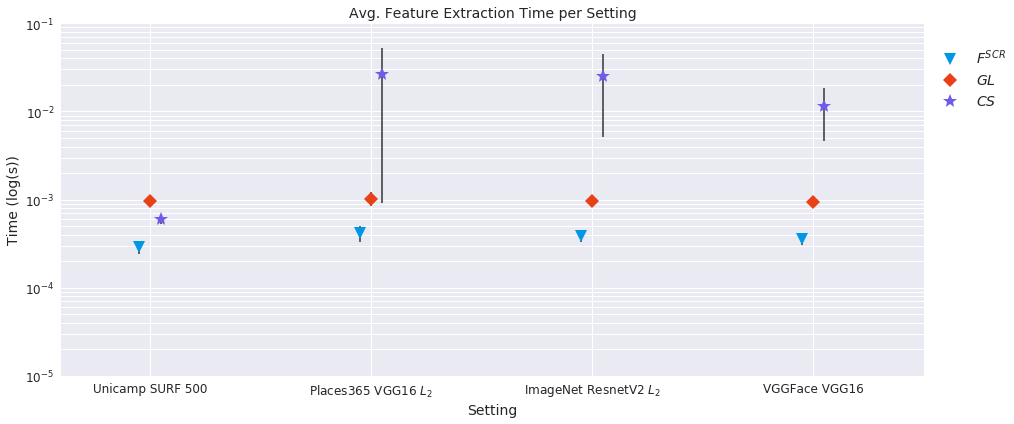

In [26]:
np.set_printoptions(precision=2, suppress=True)

key_order = ['unicamp_001',
         'places365_001',
         'imagenet_001', 
         'vggfaces_001',]

fig, axes = plt.subplots(1)
try:
    axes = axes.reshape(-1)
except AttributeError:
    axes = [axes]
fig.set_size_inches((14, 6))

top_lim = -1
bot_lim = np.inf

leg_handles = []
leg_labels = []

#x = np.arange(0.85, len(key_order)+0.7, 1)
x = np.arange(0.95, len(key_order)+0.2, 1)
xlab = [exp_aliases[k] for k in key_order]

for desc in tables:
    
    print(x)
    y = []
    s = []

    for m in key_order:
        y.append(tables[desc][m].mean())
        s.append(tables[desc][m].std())

    y = np.array(y)
    s = np.array(s)
    
    if desc == 'cs':
        s[1] = 0.026

    if (y + s).max() > top_lim:
        top_lim = (y + s).max()*1.05
    if (y - s).min() < bot_lim:
        bot_lim = (y - s).min()*0.95

    ebar = axes[0].errorbar(x, y, yerr=s, xerr=None, ecolor=(0.30, 0.30, 0.30, 1.0), linestyle='', alpha=1.0,
                           **drawargs[desc][1])
    
    #ebar = axes[0].plot(x, y, alpha=1.0, linestyle='', **drawargs[desc][1])

    leg_handles.append(ebar[0])
    leg_labels.append(drawargs[desc][0])
    
    x += 0.05
    

axes[0].set_ylim(top=10**-1, bottom=10**-5)
axes[0].set_xlim(left=x[0] - 0.5, right=x[-1] + 0.4)
axes[0].set_xticks(np.arange(1, len(key_order)+1, 1))
axes[0].set_xticklabels(xlab, ha="center", **dict(fontsize=12, rotation=0))
axes[0].set_yticklabels(axes[0].get_yticklabels(),**dict(fontsize=12, rotation=0))

axes[0].set_ylabel('Time (log(s))', **dict(fontsize=14))
axes[0].set_xlabel('Setting', **dict(fontsize=14))

axes[0].set_title('Avg. Feature Extraction Time per Setting', **dict(fontsize=14))

plt.yscale('log', nonposy='clip')
plt.grid(True, which="both")
fig.legend(leg_handles, leg_labels, fancybox=True, shadow=True, ncol=1, 
           fontsize=14, loc='center right', bbox_to_anchor=[1.01, 0.8])
fig.tight_layout()
plt.subplots_adjust(right=0.92)
plt.savefig('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/results/thesis/timing/features_struct_timing.pdf', dpi=300)

In [25]:
np.set_printoptions(precision=8, suppress=True)
print(y)
print(s)

[0.00059546 0.02692076 0.02510525 0.01160697]
[0.000071   0.02822045 0.01999924 0.00697312]


In [ ]:
np.set_printoptions(precision=2, suppress=True)